# V01 - Proyecto Parte 4

En esta parte del proyecto se continuará con una actualización del 'Proyecto Parte 3', agregando correcciones, mejoras o simples actualizaciones. Este proyecto se dividirá en las siguientes secciones:

## **Puesta al día**

Se volverán a cargar los datos y se realizarán todos los pasos de transformación aplicados en la Parte 1, sin detallar el proceso (ya fue explicado en 'Proyecto Parte 1'):
Este paso fue realizado en el 'Poryecto Parte 3':
- En este paso no solo se descartarán las observaciones con operaciones realizadas desde las 14 horas en adelante, en su lugar solo se tomarán las operaciones realizadas desde las 2am hasta las 14 pm
- La función que agrega operaciones (agregar_columnas_operaciones) ha sido actualizada, logrando reducir su tiempo de ejecución 1/25  veces el tiempo en versiones anteriores, además cambiamos a que las operaciones 1/3,1/2 y 1/1.5 se realicen en el close de la vela y no en el open como en versiones anteriores (open_price = df.at[i, 'close']) 
- Agregamos la dirección de cada bloque, bajista o alcista y la cantidad de pips que mueve ('BlockDir', 'PipsBlock')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Continuación**


**LIBRERÍAS**
- Librerías generales

In [9]:
# TensorFlow Keras
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
from tensorflow.keras.regularizers import l2

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report
)

#ibrerías especificas para la **'celda puesta al día'**

# Otras librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# para graficar las velas japonesas
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Para dibujar matriz de decisión
import seaborn as sns



**Celda de puesta al día**

In [38]:
#------------------------------------------------------------------------------------------------------------------
#| Esta celda solo se debe ejecutar si es la primera vez que se revisa este proyecto, sino, pasar a la siguiente. |
#------------------------------------------------------------------------------------------------------------------

#Load data
'''data=pd.read_csv('../Datos/US30.cash_data_m1_antiguo.csv',index_col=0,parse_dates=True)
#data.shape---->(139477, 7)
#data.columns-->Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'], dtype='object')
#-----------------------------------------PASO 1-----------------------------------------

data.index=data.index.tz_localize('Etc/GMT-3')#Localizamos el horario en el que se encuentran los datos
data.index=data.index.tz_convert('Etc/GMT+5').tz_localize(None)# cambiamos la zona horaría y al final eliminamos la zona horaria del índice

data['Year'] = data.index.year#Creamos una columna con el año del índice
data['DayOfYear'] = data.index.dayofyear#Creamos una columna con el dia del año del índice
data['Hour']=data.index.hour#Creamos una columna con la hora del índice
data['Minute']=data.index.minute#Creamos una columna con los minutos del índice

#-----------------------------------------PASO 2-----------------------------------------
data = data[~data['DayOfYear'].isin([data['DayOfYear'].min(),data['DayOfYear'].max()])]#Eliminamos el primer y ultimo día del año (este dataframe solo cuenta con datos de un año (2024))

#-----------------------------------------PASO 3-----------------------------------------

# Al solo procesar las columnas seleccionadas, la función optimiza el rendimiento, especialmente útil para DataFrames grandes.
def agregar_columnas_operaciones(df, Tres=False, Dos=False, PuntoCinco=False):
    """
    Agrega columnas de operaciones al DataFrame basado en los parámetros seleccionados,
    de manera eficiente y cumpliendo con las nuevas características.

    Parámetros:
    - df (pd.DataFrame): DataFrame original que contiene las columnas necesarias.
    - Tres (bool): Si es True, agrega y calcula las columnas 'Resultado_Tres' y 'Tiempo_Tres'.
    - Dos (bool): Si es True, agrega y calcula las columnas 'Resultado_Dos' y 'Tiempo_Dos'.
    - PuntoCinco (bool): Si es True, agrega y calcula las columnas 'Resultado_PuntoCinco' y 'Tiempo_PuntoCinco'.

    Retorna:
    - pd.DataFrame: DataFrame con las nuevas columnas agregadas según los parámetros.
    """

    import numpy as np

    # Verificar si se seleccionó al menos un parámetro
    factores = {}
    if Tres:
        factores['Tres'] = 3
        df['Resultado_Tres'] = np.nan
        df['Tiempo_Tres'] = np.nan
    if Dos:
        factores['Dos'] = 2
        df['Resultado_Dos'] = np.nan
        df['Tiempo_Dos'] = np.nan
    if PuntoCinco:
        factores['PuntoCinco'] = 1.5
        df['Resultado_PuntoCinco'] = np.nan
        df['Tiempo_PuntoCinco'] = np.nan

    if not factores:
        print("No se seleccionó ninguna columna para agregar.")
        return df

    # Parámetros fijos
    StopLoss = 30

    # Preparar cálculos de tiempo
    df['TotalMinutes'] = df['DayOfYear'] * 1440 + df['Hour'] * 60 + df['Minute']
    df['TotalMinutes_until_day_end'] = (df['DayOfYear'] + 1) * 1440 - df['TotalMinutes']
    df['max_operation_minutes'] = df['TotalMinutes_until_day_end'].clip(upper=60).astype(int)

    n = len(df)
    high_values = df['high'].values
    low_values = df['low'].values
    buy_values = df['Buy'].values
    close_values = df['close'].values
    max_operation_minutes = df['max_operation_minutes'].values

    for key, factor in factores.items():
        resultado = np.zeros(n)
        tiempo = np.zeros(n)

        for i in range(n):
            max_minutes = max_operation_minutes[i]
            if max_minutes <= 0:
                # Operación no válida, se considera pérdida
                resultado[i] = 0
                tiempo[i] = 0
                continue

            buy = buy_values[i]
            open_price = close_values[i]

            # Calcular precios de SL y TP
            if buy == 1:
                SL_price = open_price - StopLoss
                TP_price = open_price + StopLoss * factor
            else:
                SL_price = open_price + StopLoss
                TP_price = open_price - StopLoss * factor

            # Obtener valores futuros de high y low
            end_idx = min(i + max_minutes, n - 1)
            future_highs = high_values[i + 1:end_idx + 1]
            future_lows = low_values[i + 1:end_idx + 1]

            # Verificar si se alcanza TP o SL
            if buy == 1:
                hit_tp = np.where(future_highs >= TP_price)[0]
                hit_sl = np.where(future_lows <= SL_price)[0]
            else:
                hit_tp = np.where(future_lows <= TP_price)[0]
                hit_sl = np.where(future_highs >= SL_price)[0]

            # Determinar el evento más temprano
            tp_time = hit_tp[0] + 1 if len(hit_tp) > 0 else None
            sl_time = hit_sl[0] + 1 if len(hit_sl) > 0 else None

            if tp_time is not None and (sl_time is None or tp_time <= sl_time):
                resultado[i] = 1  # Ganó
                tiempo[i] = tp_time
            elif sl_time is not None:
                resultado[i] = 0  # Perdió
                tiempo[i] = sl_time
            else:
                # Ni TP ni SL alcanzados dentro del tiempo máximo, se considera pérdida
                resultado[i] = 0
                tiempo[i] = max_minutes

        df[f'Resultado_{key}'] = resultado
        df[f'Tiempo_{key}'] = tiempo

    # Eliminar columnas temporales
    df.drop(columns=['TotalMinutes', 'TotalMinutes_until_day_end', 'max_operation_minutes'], inplace=True)

    return df

# Creamos los DataFrames de Buys y Sells
Buys=data.copy()
Sells=data.copy()
Buys['Buy']=1
Sells['Buy']=0
Buys = agregar_columnas_operaciones(Buys,True)#Agregamos las columnas de operaciones
Sells = agregar_columnas_operaciones(Sells,True)#Agregamos las columnas de operaciones

#-----------------------------------------PASO 4-----------------------------------------
Buys=Buys.drop(['spread','real_volume','Year'],axis=1).copy() #Eliminamos las columnas que no necesitamos
Sells=Sells.drop(['spread','real_volume','Year'],axis=1).copy() #Eliminamos las columnas que no necesitamos
#Las columnas que contienen hasta aquí son:
#Buys.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres'],dtype='object')
#Sells.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres'],dtype='object')

#-----------------------------------------PASO 5-----------------------------------------
def agregar_atr_rsi(df, periodo_atr, periodo_rsi):
    """
    Agrega columnas ATR y RSI al DataFrame, calculadas por día del año.

    Parámetros:
    - df: pandas DataFrame con columnas ['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Resultado_Tres', 'Tiempo_Tres']
    - periodo_atr: int, el período para calcular el ATR
    - periodo_rsi: int, el período para calcular el RSI

    Retorna:
    - pandas DataFrame con nuevas columnas 'ATR{periodo_atr}' y 'RSI{periodo_rsi}'
    """
    # Asegurar que el DataFrame está ordenado correctamente
    df = df.sort_index()

    ### Cálculo del ATR ###

    # Calcular el Close anterior por día
    df['prev_close'] = df.groupby('DayOfYear')['close'].shift(1)

    # Calcular el True Range (TR)
    df['TR'] = df.apply(
        lambda row: max(
            row['high'] - row['low'],
            abs(row['high'] - row['prev_close']) if not pd.isna(row['prev_close']) else row['high'] - row['low'],
            abs(row['low'] - row['prev_close']) if not pd.isna(row['prev_close']) else row['high'] - row['low']
        ),
        axis=1
    )

    # Definir el nombre de la nueva columna ATR
    atr_column = f'ATR{periodo_atr}'

    # Calcular el ATR como media móvil simple del TR por grupo (día)
    df[atr_column] = df.groupby('DayOfYear')['TR'].transform(
        lambda x: x.rolling(window=periodo_atr, min_periods=periodo_atr).mean()
    )

    # Reemplazar los valores NaN (primeras observaciones) por 0
    df[atr_column] = df[atr_column].fillna(0)

    # Redondear el ATR para mayor claridad
    df[atr_column] = df[atr_column].round(4)

    ### Cálculo del RSI ###

    # Definir el nombre de la nueva columna RSI
    rsi_column = f'RSI{periodo_rsi}'

    # Definir la función calculate_rsi dentro del ámbito para acceder a 'periodo_rsi'
    def calculate_rsi(close_series):
        delta = close_series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        # Usar EMA para promedio de ganancias y pérdidas
        avg_gain = gain.ewm(alpha=1/periodo_rsi, min_periods=periodo_rsi, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/periodo_rsi, min_periods=periodo_rsi, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        # Reemplazar NaN iniciales por 0
        rsi = rsi.fillna(0)

        return rsi

    # Calcular el RSI por grupo (día), seleccionando sólo la columna 'close'
    df[rsi_column] = df.groupby('DayOfYear', group_keys=False)['close'].apply(calculate_rsi)

    # Redondear el RSI para mayor claridad
    df[rsi_column] = df[rsi_column].round(2)

    # Eliminar columnas auxiliares
    df = df.drop(columns=['prev_close', 'TR'])

    return df

Buys=agregar_atr_rsi(Buys,14,14) #Agregamos la columna ATR
Sells=agregar_atr_rsi(Sells,14,14) #Agregamos la columna ATR
#Las columnas que contienen hasta aquí son:
#Buys.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14'],dtype='object')
#Sells.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14'],dtype='object')

#-----------------------------------------PASO 6-----------------------------------------
def agregar_max_min(df, n):
    """
    Agrega las columnas 'maximo' y 'minimo' al DataFrame.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene las columnas ['open', 'high', 'low', 'close'].
    - n (int): Número de observaciones anteriores y posteriores a considerar.
    
    Retorna:
    - pd.DataFrame: DataFrame original con las columnas 'maximo' y 'minimo' agregadas.
    """
    # Asegurarse de que el DataFrame está ordenado correctamente (opcional)
    # df = df.sort_index()

    # Calcular el máximo en una ventana de 2n+1 centrada en cada observación
    rolling_max = df['high'].rolling(window=2*n+1, center=True).max()
    # Asignar 1 si el 'high' actual es igual al máximo de la ventana, de lo contrario 0
    df['maximo'] = (df['high'] == rolling_max).astype(int)
    
    # Calcular el mínimo en una ventana de 2n+1 centrada en cada observación
    rolling_min = df['low'].rolling(window=2*n+1, center=True).min()
    # Asignar 1 si el 'low' actual es igual al mínimo de la ventana, de lo contrario 0
    df['minimo'] = (df['low'] == rolling_min).astype(int)
    
    # Opcional: Reemplazar NaN en las primeras y últimas n filas con 0
    df['maximo'] = df['maximo'].fillna(0).astype(int)
    df['minimo'] = df['minimo'].fillna(0).astype(int)
    
    return df

Buys=agregar_max_min(Buys,4)
Sells=agregar_max_min(Sells,4)
#Las columnas que contienen hasta aquí son:
#Buys.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo'],dtype='object')
#Sells.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo'],dtype='object')

#-----------------------------------------PASO 7-----------------------------------------

def agregar_columnas_pips_y_direccion(df):
    """
    Agrega dos columnas al DataFrame: 'PipsBlock' y 'BlockDir'.
    - 'PipsBlock' contiene el valor absoluto de la diferencia entre 'open' y 'close' (movimiento en pips).
    - 'BlockDir' indica la dirección del bloque: 1 para alcista (subida), 0 para bajista (bajada).

    Parámetros:
    - df (pd.DataFrame): El DataFrame original que contiene las columnas 'open', 'high', 'close' y 'low'.

    Retorna:
    - pd.DataFrame: El DataFrame con las nuevas columnas agregadas.
    """
    # Calcular la cantidad de pips en el bloque
    df['PipsBlock'] = (df['close'] - df['open']).abs()

    # Determinar la dirección del bloque
    df['BlockDir'] = (df['close'] > df['open']).astype(int)

    return df
Buys=agregar_columnas_pips_y_direccion(Buys)
Sells=agregar_columnas_pips_y_direccion(Sells)
#Las columnas que contienen hasta aquí son:
#Buys.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir'],dtype='object')
#Sells.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir'],dtype='object')
#-----------------------------------------PASO 8-----------------------------------------
#Elimino los horarios que no son de mi interes
Buys=Buys[Buys['Hour'].isin(list(range(2,15)))].copy()
Sells=Sells[Sells['Hour'].isin(list(range(2,15)))].copy()
#Si quieres graficar las horas en este punto, descomenta la siguiente linea
#Sells[Sells['Resultado_Tres']==1]['Hour'].value_counts().sort_index().plot(kind='bar',title='Cantidad de operaciones exitosas por hora',color='blue')
#Si quieres los tiempos que tarda en llegar al TP o SL, descomenta la siguiente linea
#Buys[Buys['Resultado_Tres']==1]['Tiempo_Tres'].plot(kind='hist',title='Histograma de tiempo de operaciones exitosas',color='blue',bins=30)
#Buys[Buys['Resultado_Tres']==0]['Tiempo_Tres'].plot(kind='hist',title='Histograma de tiempo de operaciones fallidas',color='blue',bins=30)
#Las columnas que contienen hasta aquí son:
#Buys.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir'],dtype='object')
#Sells.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir'],dtype='object')

#-----------------------------------------PASO 8-----------------------------------------
Buys.to_csv('Buys.csv', index=True)#Guardamos los datos en un archivo csv
Sells.to_csv('Sells.csv', index=True)'''

#Ultima ejecución en 9.4 segundos

CARGAMOS LOS DATOS

In [2]:
#Las columnas que contienen hasta aquí son:
#Buys.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir'],dtype='object')
#Sells.columns=Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour', 'Minute', 'Buy', 'Resultado_Tres', 'Tiempo_Tres', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir'],dtype='object')
Buys = pd.read_csv('Buys.csv', index_col=0, parse_dates=True) #Cargamos los dato y en el futuro Sells
#Sells= pd.read_csv('Sells.csv', index_col=0, parse_dates=True) #Cargamos los dato y en el futuro Sells                          #<<<<<-------------------------

#Para ver cuantas operciones exitosas por día hay 
#Buys.query('Resultado_Tres == 1 and DayOfYear == 149')['Hour'].value_counts()

FUNCIÓN PARA GRAFICAR LAS OPERACIONES GANADORAS DE CADA DÍA

In [8]:
def plot_winning_trades(df, day_of_year):
    """
    Plots the winning trades for a given day of the year.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the trading data.
    - day_of_year (int): The day of the year to plot the trades for.

    Returns:
    - None: Displays the plot.
    """

    # Filter the DataFrame for the specified day
    df_day = df[df['DayOfYear'] == day_of_year]

    # Ensure the 'time' column exists or set the index as 'time'
    if 'time' in df_day.columns:
        df_day = df_day.set_index('time')
    else:
        df_day = df_day.copy()
        df_day['time'] = df_day.index

    # Combine Buys and Sells if necessary
    # df_day = pd.concat([Buys_day, Sells_day])

    # Create the figure with subplots
    fig = make_subplots(rows=1, cols=1)

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df_day['time'],
        open=df_day['open'],
        high=df_day['high'],
        low=df_day['low'],
        close=df_day['close'],
        name='Candlesticks'
    ))

    # Update layout
    fig.update_layout(
        title=f"Winning Trades on Day {day_of_year}",
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False
    )

    # Define the factors and their corresponding take profits
    factors = {
        'Tres': 3,
        'Dos': 2,
        'PuntoCinco': 1.5
    }

    # Loop through each trade in the DataFrame
    for index, row in df_day.iterrows():
        entry_time = row['time']
        entry_price = row['close']
        buy = row['Buy']

        # Loop through each factor to check for winning trades
        for key, factor in factors.items():
            resultado_col = f'Resultado_{key}'
            tiempo_col = f'Tiempo_{key}'

            # Check if the result column exists and if the trade was won
            if resultado_col in row and row[resultado_col] == 1:
                # Calculate Stop Loss and Take Profit prices
                StopLoss = 30
                if buy == 1:
                    SL_price = entry_price - StopLoss
                    TP_price = entry_price + StopLoss * factor
                else:
                    SL_price = entry_price + StopLoss
                    TP_price = entry_price - StopLoss * factor

                # Calculate exit time based on the duration of the trade
                exit_time = entry_time + pd.Timedelta(minutes=row[tiempo_col])

                # Draw the Stop Loss area (red rectangle)
                fig.add_shape(type="rect",
                              x0=entry_time, x1=exit_time,
                              y0=min(entry_price, SL_price),
                              y1=max(entry_price, SL_price),
                              fillcolor="red",
                              opacity=0.2,
                              line=dict(color="red"),
                              row=1, col=1)

                # Draw the Take Profit area (green rectangle)
                fig.add_shape(type="rect",
                              x0=entry_time, x1=exit_time,
                              y0=min(entry_price, TP_price),
                              y1=max(entry_price, TP_price),
                              fillcolor="green",
                              opacity=0.2,
                              line=dict(color="green"),
                              row=1, col=1)

                # Add entry and exit markers
                fig.add_trace(go.Scatter(
                    x=[entry_time],
                    y=[entry_price],
                    mode='markers',
                    marker=dict(color='blue', size=8),
                    name='Entry',
                    showlegend=False
                ))
                fig.add_trace(go.Scatter(
                    x=[exit_time],
                    y=[TP_price],
                    mode='markers',
                    marker=dict(color='green', size=8),
                    name='Exit',
                    showlegend=False
                ))

    # Show the plot
    fig.show()

# Plot the winning trades for a specific day of the year
#plot_winning_trades(Buys, 149)

NORMALIZACIÓN

In [3]:
#----------------------------------------PASO 2:--------------------------------------------
columnas_a_normalizar = ['open', 'high', 'low', 'close', 'tick_volume', 'Hour', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir'] #Columnas usadas en el entrenamiento

# Crear un objeto de MinMaxScaler
scaler = MinMaxScaler()

# Normaliza solo las columnas seleccionadas
Scaled_Buys = Buys.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas
Scaled_Buys[columnas_a_normalizar] = scaler.fit_transform(Buys[columnas_a_normalizar])

# Hacer lo mismo para el dataframe de Sells
#Scaled_Sells = Sells.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas                          #<<<<<-------------------------
#Scaled_Sells[columnas_a_normalizar] = scaler.fit_transform(Sells[columnas_a_normalizar])                          #<<<<<-------------------------

CREAMOS SECUENCIAS PARA EL ENTRENAMIENTO

In [4]:
def crear_secuencias(df, Y, objetivo,variables):
    """
    Crea conjuntos de secuencias y sus respectivos targets a partir de un DataFrame.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las columnas ['open', 'high', 'low', 'close', 
                       'tick_volume', 'spread', 'real_volume', 'DayOfYear', 'Hour', 
                       'Minute', 'Tres'] ya estandarizadas.
    Y (int): Número de observaciones en cada secuencia.

    Retorna:
    X (np.ndarray): Arreglo de secuencias con forma (a, Y, b), donde:
                    a = número de secuencias,
                    Y = longitud de cada secuencia,
                    b = número de características (sin incluir 'DayOfYear' y 'Tres').
    y (np.ndarray): Arreglo de targets con forma (a, 1).
    """
    # Definir las columnas de características excluyendo 'DayOfYear' y 'Tres'
    caracteristicas = variables
    
    # Inicializar listas para almacenar secuencias y targets
    secuencias = []
    targets = []
    
    # Agrupar el DataFrame por 'DayOfYear'
    grupos_dia = df.groupby('DayOfYear')
    
    for dia, grupo in grupos_dia:
        # Asegurarse de que los datos estén ordenados por 'Hour' y 'Minute'
        grupo_ordenado = grupo#grupo.sort_values(['Hour', 'Minute']).reset_index(drop=True) #El dataset ya esta ordenado
        
        # Extraer los valores de las características y del target
        datos_caracteristicas = grupo_ordenado[caracteristicas].values
        datos_target = grupo_ordenado[objetivo].values
        
        # Crear secuencias con ventana deslizante
        for i in range(len(grupo_ordenado) - Y + 1):
            secuencia = datos_caracteristicas[i:i+Y]
            target = datos_target[i+Y-1]
            
            secuencias.append(secuencia)
            targets.append(target)
    
    # Convertir las listas a arreglos de NumPy
    X = np.array(secuencias)
    y = np.array(targets).reshape(-1, 1)
    
    return X, y

columnas_a_incluir=['open', 'high', 'low', 'close', 'tick_volume', 'Hour', 'ATR14', 'RSI14', 'maximo', 'minimo', 'PipsBlock', 'BlockDir']#No se incluyen los minutos
Xb_t, yb_t = crear_secuencias(Scaled_Buys, 200,'Resultado_Tres',columnas_a_incluir)
#Xs_t, ys_t= crear_secuencias(Scaled_Sells, 300,'Tres',columnas_a_incluir)                          #<<<<<-------------------------

#Nota: No es necesario mezclar las secuencias ya que por defecto, la función model.fit() de Keras mezcla automáticamente las muestras antes de cada epoch. Esto lo hace con el parámetro shuffle=True, que es el comportamiento predeterminado.

In [5]:
#----------------------------------------MODELO RATIO 1/3--------------------------------------------
Xbt_train, Xbt_val, ybt_train, ybt_val = train_test_split(Xb_t, yb_t, test_size=0.50, random_state=42, shuffle=False)#Solo trabajaremos con el 50% de los datos
#Xst_train, Xst_val, yst_train, yst_val = train_test_split(Xs_t_balanced, ys_t_balanced, test_size=0.25, random_state=42, shuffle=False)                          #<<<<<-------------------------

In [6]:
def balancear_clases(X, y, metodo='over', random_state=None):
    """
    Equilibra las clases de un conjunto de datos mediante oversampling o undersampling.
    
    Parámetros:
    - X (np.ndarray): Arreglo de características con forma (num_muestras, longitud_secuencia, num_caracteristicas).
    - y (np.ndarray): Arreglo de etiquetas con forma (num_muestras, 1) o (num_muestras,).
    - metodo (str): Método de balanceo a utilizar. Puede ser 'over' para oversampling o 'under' para undersampling.
    - random_state (int, opcional): Semilla para reproducibilidad.
    
    Retorna:
    - X_balanceado (np.ndarray): Arreglo de características balanceado.
    - y_balanceado (np.ndarray): Arreglo de etiquetas balanceado.
    """
    if metodo not in ['over', 'under']:
        raise ValueError("El parámetro 'metodo' debe ser 'over' o 'under'.")
    
    # Asegurar que y sea 1D
    y = y.flatten()
    
    # Obtener los índices de cada clase
    clases, conteos = np.unique(y, return_counts=True)
    
    if len(clases) != 2:
        raise ValueError("Esta función solo soporta problemas de clasificación binaria.")
    
    clase_majoritaria = clases[np.argmax(conteos)]
    clase_minoritaria = clases[np.argmin(conteos)]
    conteo_majoritaria = np.max(conteos)
    conteo_minoritaria = np.min(conteos)
    
    print(f"Distribución original de clases: {dict(zip(clases, conteos))}")
    
    if conteo_majoritaria == conteo_minoritaria:
        print("Las clases ya están balanceadas. No se requiere balanceo.")
        return X, y.reshape(-1, 1)
    
    if metodo == 'over':
        # Cálculo de cuántas muestras se necesitan agregar
        cantidad_a_agregar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando oversampling. Se agregarán {cantidad_a_agregar} muestras a la clase {clase_minoritaria}.")
        
        # Obtener los índices de la clase minoritaria
        indices_minoritaria = np.where(y == clase_minoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente con reemplazo
        indices_agregar = np.random.choice(indices_minoritaria, size=cantidad_a_agregar, replace=True)
        
        # Crear las nuevas muestras
        X_agregar = X[indices_agregar]
        y_agregar = y[indices_agregar]
        
        # Concatenar las muestras nuevas con las originales
        X_balanceado = np.concatenate([X, X_agregar], axis=0)
        y_balanceado = np.concatenate([y, y_agregar], axis=0)
    
    elif metodo == 'under':
        # Cálculo de cuántas muestras se deben eliminar
        cantidad_a_eliminar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando undersampling. Se eliminarán {cantidad_a_eliminar} muestras de la clase {clase_majoritaria}.")
        
        # Obtener los índices de la clase majoritaria
        indices_majoritaria = np.where(y == clase_majoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente sin reemplazo
        indices_eliminar = np.random.choice(indices_majoritaria, size=cantidad_a_eliminar, replace=False)
        
        # Crear una máscara para mantener las muestras no eliminadas
        mascara = np.ones(len(y), dtype=bool)
        mascara[indices_eliminar] = False
        
        # Aplicar la máscara
        X_balanceado = X[mascara]
        y_balanceado = y[mascara]
    
    # Mezclar las muestras balanceadas para evitar cualquier sesgo de orden
    if metodo == 'over':
        # Solo en oversampling se agregan nuevas muestras, por lo que es útil mezclar
        indices_mezclar = np.arange(len(y_balanceado))
        np.random.shuffle(indices_mezclar)
        X_balanceado = X_balanceado[indices_mezclar]
        y_balanceado = y_balanceado[indices_mezclar]
    
    print(f"Distribución de clases después del balanceo: {dict(zip(*np.unique(y_balanceado, return_counts=True)))}")
    
    return X_balanceado, y_balanceado.reshape(-1, 1)

Xb_t_balanced,yb_t_balanced=balancear_clases(Xbt_train, ybt_train, metodo='over', random_state=42)
#Xs_t_balanced,ys_t_balanced=balancear_clases(Xs_t_subset, ys_t_subset, metodo='over', random_state=42)                          #<<<<<-------------------------

Distribución original de clases: {0.0: 20652, 1.0: 3835}
Aplicando oversampling. Se agregarán 16817 muestras a la clase 1.0.
Distribución de clases después del balanceo: {0.0: 20652, 1.0: 20652}


Se dividirán las secuencias en conjunto de entrenamiento y validación.

ENTRENAMIENTO

MODELO 1

In [23]:
# Input layer
inputs = Input(shape=(Xb_t_balanced.shape[1], Xb_t_balanced.shape[2]))

# Convolutional branch
conv = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.005))(inputs)
conv = BatchNormalization()(conv)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Flatten()(conv)

# LSTM branch
lstm = LSTM(90, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.005))(inputs)
lstm = BatchNormalization()(lstm)

# Combine convolutional and LSTM features
combined = concatenate([conv, lstm])

# Fully connected layers
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(combined)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
classes = np.unique(yb_t_balanced)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=yb_t_balanced.flatten())
class_weights = dict(zip(classes, class_weights))

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    Xb_t_balanced, yb_t_balanced,
    epochs=20,
    batch_size=32,
    validation_data=(Xbt_val, ybt_val),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 111s 84ms/step - accuracy: 0.5353 - loss: 1.2456 - val_accuracy: 0.3452 - val_loss: 0.8588
Epoch 2/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 108s 84ms/step - accuracy: 0.6660 - loss: 0.7834 - val_accuracy: 0.5843 - val_loss: 1.0199
Epoch 3/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 108s 84ms/step - accuracy: 0.7819 - loss: 0.7811 - val_accuracy: 0.6616 - val_loss: 1.0994
Epoch 4/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 107s 83ms/step - accuracy: 0.8358 - loss: 0.7411 - val_accuracy: 0.6605 - val_loss: 1.0562
Epoch 5/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 107s 83ms/step - accuracy: 0.8529 - loss: 0.7100 - val_accuracy: 0.7236 - val_loss: 1.1204
Epoch 6/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 107s 83ms/step - accuracy: 0.8646 - loss: 0.6945 - val_accuracy: 0.5866 - val_loss: 1.3191


# MÉTRICAS

In [26]:
# -----------------------------------------------------
# 1. Realizar Predicciones
# -----------------------------------------------------
Xs=[Xb_t,#Dataset completo
    Xb_t_balanced,#Balanceado
    Xbt_train,#Entrenamiento
    Xbt_val]#Validación
ys=[yb_t,yb_t_balanced,ybt_train,ybt_val]

# Seleccionar el conjunto de datos a evaluar
select_set=3#Lo probamos con el datset completo
X_metrics=Xs[select_set]
y_metrics=ys[select_set]
# Obtener las predicciones de probabilidad
y_pred_prob = model.predict(X_metrics)

# Convertir las predicciones de probabilidad a clases binarias (0 o 1) usando un umbral de 0.5
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)


# Asegurarse de que ybt_val también esté en formato 1D
y_true = y_metrics.reshape(-1)

# -----------------------------------------------------
# 2. Calcular las Métricas
# -----------------------------------------------------

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_true, y_pred_prob)

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Generar el reporte de clasificación
class_report = classification_report(y_true, y_pred, digits=4)

# -----------------------------------------------------
# 3. Presentar las Métricas
# -----------------------------------------------------
# Crear un DataFrame para las métricas
metrics_df = pd.DataFrame({
    'Métrica': ['Exactitud (Accuracy)', 'Precisión (Precision)', 
                'Sensibilidad (Recall)', 'F1-Score', 'AUC-ROC'],
    'Valor': [accuracy, precision, recall, f1, auc_roc]
    })
print("### Reporte de Métricas ###\n")
print(metrics_df)
print("\n### Reporte de Clasificación ###\n")
print(class_report)

766/766 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step
### Reporte de Métricas ###

                 Métrica     Valor
0   Exactitud (Accuracy)  0.345244
1  Precisión (Precision)  0.205353
2  Sensibilidad (Recall)  0.798768
3               F1-Score  0.326712
4                AUC-ROC  0.524509

### Reporte de Clasificación ###

              precision    recall  f1-score   support

         0.0     0.8232    0.2327    0.3628     19617
         1.0     0.2054    0.7988    0.3267      4870

    accuracy                         0.3452     24487
   macro avg     0.5143    0.5157    0.3447     24487
weighted avg     0.7003    0.3452    0.3556     24487



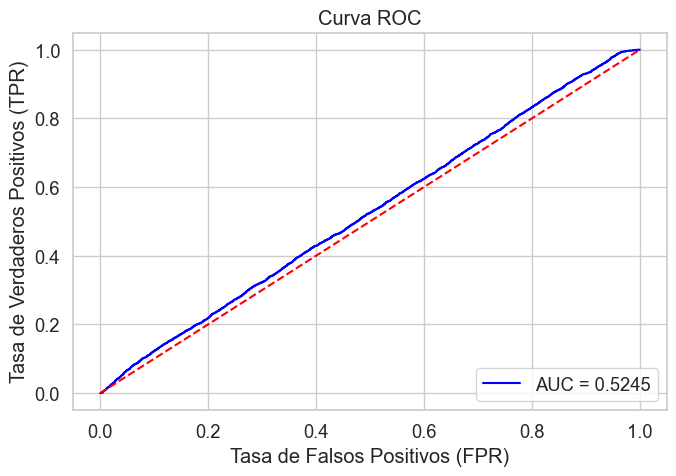

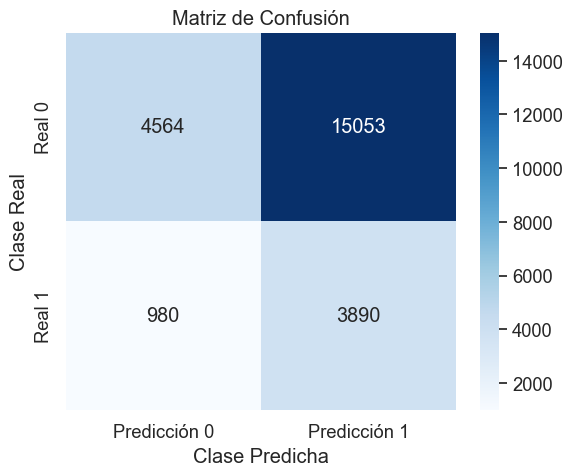

In [27]:
# -----------------------------------------------------
# 4. Generar los Gráficos
# -----------------------------------------------------
# Configuración general de los gráficos
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# a) Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# b) Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# CONCLUSIÓN
En esta versión del proyecto, se ha logrado construir una arquitectura que muestra un buen desempeño con series temporales. En particular, se han incorporado redes convolucionales y se han añadido nuevas columnas de características al conjunto de datos, como 'BlockDir' y 'PipsBlock'. No obstante, los resultados indican que las características proporcionadas no son suficientes para desarrollar un modelo que prediga con precisión la variable objetivo. Como se observa en la curva ROC, las predicciones tienden a acercarse a la aleatoriedad, lo que sugiere que la estrategia implementada en este proyecto no es efectiva. Esto equivale a operar de manera aleatoria, ya que las características recopiladas con base en la estrategia no contribuyen significativamente a la predicción de la variable objetivo. A pesar de haber aplicado numerosas técnicas para evitar el sobreajuste, como la regularización L2, el uso de dropout, y el equilibrio entre los filtros de la capa convolucional, las unidades de memoria en la red LSTM y las neuronas de la capa densa, el modelo sigue sufriendo de overfitting.

### Reporte de Métricas ###

|        | Predicción 0 | Predicción 1 |
|--------|--------------|--------------|
| Real 0 | 4564         | 15053        | 
| Real 1 | 980          | 3890         |

Las métricas son: 



| Métrica                   | Valor   |
|---------------------------|---------|
| Exactitud (Accuracy)      | 0.345244|
| Precisión (Precision)     | 0.205353|
| Sensibilidad (Recall)     | 0.798768|
| F1-Score                  | 0.326712|
| AUC-ROC                   | 0.524509|



Nota: No continuaremos con esta estrategia, sin embargo aquí se han demostrado varios conceptos importante en campo del aprendizaje profundo (deep learning).

HABILIDADES NECESARIAS PARA EL DESARROLLO DE ESTE PROYECTO

Manejo del overfitting
- Dropout
- Regularización L1 y L2
- Balance entre neuronas (FNNs), filtros (CNNs) y celdas de memoria (LSTM)

Equilibrio de clases
- Undersampling
- Oversampling
- compute_class_weight de sklearn.utils

Diferentes arquitecturas de deep learning
- Redes neuronales convolucionales 1D
- Redes LSTM
- Redes totalmente conectadas

Funciones de pérdida
- Sigmoide
- ReLU
- Softmax
- etc.

Funciones de activación
- Binary crossentropy
- Sparse categorical crossentropy

Métricas para clasificación binaria o multiclase
- Matriz de confusión
- Precision score
- Accuracy
- F1 score
- Curva ROC
- Valor AUC
- etc.

Se demostró habilidad en el manejo de las siguientes librerías:

- Pandas
- Numpy
- TensorFlow
- Scikit-learn

